In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from pathlib import Path
import torch
import sys
import os
import math
sys.path.append("..")
sys.path.append('../scripts/')
from query_res import *
import pickle

In [2]:
"""
Built indexes of size 16 (1258 indexes)
    Index add time: 16.76579, 0.01333 per index
    Build time: 7.51236, 0.00597 per index
    CPU build time: 18.18460, 0.01446 per index

Built indexes of size 64 (315 indexes)
    Index add time: 15.09311, 0.04791 per index
    Build time: 1.67339, 0.00531 per index
    CPU build time: 4.66592, 0.01481 per index

Built indexes of size 128 (158 indexes)
    Index add time: 14.76481, 0.09345 per index
    Build time: 0.88575, 0.00561 per index
    CPU build time: 2.59277, 0.01641 per index

Built indexes of size 512 (40 indexes)
    Index add time: 14.01600, 0.35040 per index
    Build time: 0.21929, 0.00548 per index
    CPU build time: 0.81992, 0.02050 per index

Built indexes of size 1024 (20 indexes)
    Index add time: 13.96358, 0.69818 per index
    Build time: 6.54531, 0.32727 per index
    CPU build time: 44.62623, 2.23131 per index

Built indexes of size 4096 (5 indexes)
    Index add time: 14.04538, 2.80908 per index
    Build time: 13.36107, 2.67221 per index
    CPU build time: 86.67032, 17.33406 per index

Built indexes of size 8192 (3 indexes)
    Index add time: 14.58335, 4.86112 per index
    Build time: 14.45715, 4.81905 per index
    CPU build time: 100.21969, 33.40656 per index

Built indexes of size 20120 (1 indexes)
    Index add time: 13.83542, 13.83542 per index
    Build time: 23.69565, 23.69565 per index
    CPU build time: 157.91386, 157.91386 per index
""";

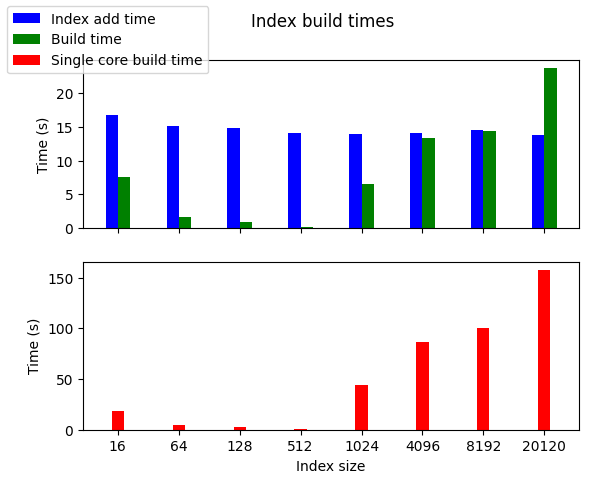

In [3]:
index_sizes = [16, 64, 128, 512, 1024, 4096, 8192, 20120]
index_add_times = [16.76579, 15.09311, 14.76481, 14.01600, 13.96358, 14.04538, 14.58335, 13.83542]
build_times = [7.51236, 1.67339, 0.88575, 0.21929, 6.54531, 13.36107, 14.45715, 23.69565]
cpu_build_times = [18.18460, 4.66592, 2.59277, 0.81992, 44.62623, 86.67032, 100.21969, 157.91386]
x = np.arange(len(index_sizes))

# https://stackoverflow.com/questions/14270391/python-matplotlib-multiple-bars
fig, axs = plt.subplots(2, sharex=True)
fig.suptitle("Index build times")
ax = axs[0]
ax.bar(x - 0.1, index_add_times, width=0.2, color='b', align='center')
ax.bar(x + 0.1, build_times, width=0.2, color='g', align='center')
ax.set_ylabel("Time (s)")

ax = axs[1]
ax.bar(x, cpu_build_times, width=0.2, color='r', align='center')
ax.set_xticks(x, index_sizes)
ax.set_xlabel("Index size")
ax.set_ylabel("Time (s)")

fig.legend(('Index add time', 'Build time', 'Single core build time'), loc='upper left')
plt.show()
fig.savefig("../assets/images/index_build_times.png")

In [22]:
import pickle
imagewise_queries = pickle.load(open("../assets/imagewise_ann_queries_top5.pkl", "rb"))
querywise_queries = pickle.load(open("../assets/querywise_ann_queries_top5.pkl", "rb"))

In [23]:
image_dir = Path("/Volumes/T7/ILSVRC/Data/DET/val")
image_paths = [image_dir / file for file in os.listdir(image_dir)]

In [24]:
from clip_index.imagenet import ImagenetDETDataset

imagenet_root = Path("/Volumes/T7/ILSVRC/")
imagenet_synset = Path("../assets/imagenet_synset_det.txt")

dataset = ImagenetDETDataset(imagenet_root, imagenet_synset)

queries = [cls for cls in dataset._synset2desc.values()]


In [7]:
image_embeddings = torch.load("../assets/image_embeddings.pt")
query_embeddings = torch.load("../assets/query_embeddings.pt")

image_embeddings.shape, query_embeddings.shape

(torch.Size([20120, 512]), torch.Size([200, 512]))

In [26]:
nimgs = len(image_paths)
correct_classes_imgs = [dataset.get_classes_from_image_path(image_paths[i]) for i in range(nimgs)]

In [ ]:
i = 0
imagewise_queries[512][i], dataset.get_classes_from_image_path(image_paths[i])

([AnnoyImage(query='car', dist=1.0219215154647827, ref_id=0, index_id=0, image_id=0, image_path=PosixPath('/Volumes/T7/ILSVRC/Data/DET/val/ILSVRC2012_val_00036091.JPEG'), imagenet_classes=None),
  AnnoyImage(query='harmonica', dist=1.1797947883605957, ref_id=0, index_id=0, image_id=0, image_path=PosixPath('/Volumes/T7/ILSVRC/Data/DET/val/ILSVRC2012_val_00036091.JPEG'), imagenet_classes=None),
  AnnoyImage(query='lemon', dist=1.2336572408676147, ref_id=0, index_id=0, image_id=0, image_path=PosixPath('/Volumes/T7/ILSVRC/Data/DET/val/ILSVRC2012_val_00036091.JPEG'), imagenet_classes=None),
  AnnoyImage(query='cucumber', dist=1.248984694480896, ref_id=0, index_id=0, image_id=0, image_path=PosixPath('/Volumes/T7/ILSVRC/Data/DET/val/ILSVRC2012_val_00036091.JPEG'), imagenet_classes=None),
  AnnoyImage(query='sunglasses', dist=1.2565724849700928, ref_id=0, index_id=0, image_id=0, image_path=PosixPath('/Volumes/T7/ILSVRC/Data/DET/val/ILSVRC2012_val_00036091.JPEG'), imagenet_classes=None)],
 ['ca

In [18]:
def get_top1_top5_accuracy(index_size_queries: dict[int, ImagewiseResult], nimgs=len(image_paths)):
    top1_accuracys = []
    top5_accuracys = []
    for _, ann_queries in index_size_queries.items():
        top_1_correct = 0
        top_5_correct = 0
        # Imagewise retrieval
        for i, ann_imgs in enumerate(ann_queries):
            if len(ann_imgs) == 0:
                continue

            correct_classes = correct_classes_imgs[i]

            # TOP 1
            predicted_class = ann_imgs[0].query
            if predicted_class in correct_classes:
                top_1_correct += 1

            # TOP 5
            predicted_classes = [ann_img.query for ann_img in ann_imgs[:5]]
            if any([cls in correct_classes for cls in predicted_classes]):
                top_5_correct += 1

        top1_accuracy = top_1_correct / nimgs
        top5_accuracy = top_5_correct / nimgs
        top1_accuracys.append(top1_accuracy)
        top5_accuracys.append(top5_accuracy)
    return top1_accuracys, top5_accuracys

In [ ]:
# {max_results: {index_size: [[top 5 Annoy Images]]}}
imagewise_max_results = pickle.load(open("../assets/imagewise_ann_queries_max_results_all_indexes.pkl", "rb"))

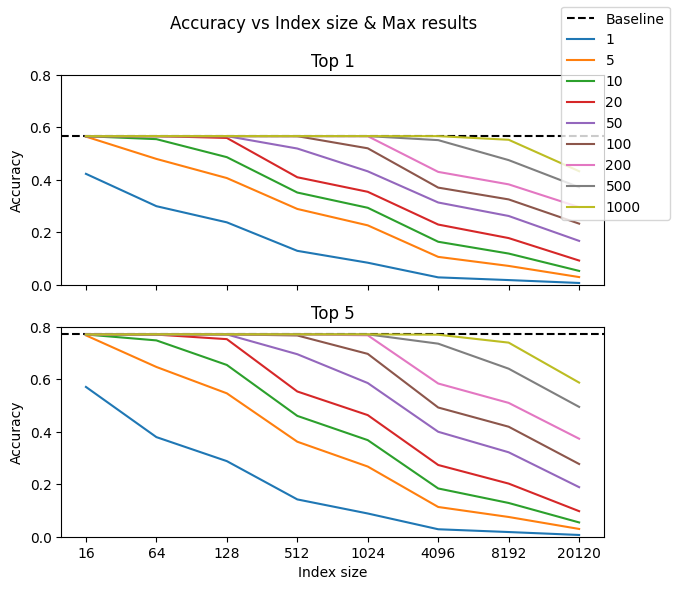

In [154]:
from matplotlib import cm

index_sizes = list(imagewise_max_results[1].keys())
max_results = list(imagewise_max_results.keys())

top1_noindex_accuracy = 0.566
top5_noindex_accuracy = 0.771

colors = cm.rainbow(np.linspace(0, 1, len(max_results)))

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(7, 6))

ax1.axhline(y=top1_noindex_accuracy, linestyle='--', c='k', label='Baseline')
ax2.axhline(y=top5_noindex_accuracy, linestyle='--', c='k')

for i, maxr in enumerate(max_results):
    res = imagewise_max_results[maxr]
    res_data = {k: v['data'] for k, v in res.items()}
    top1_accuracys, top5_accuracys = get_top1_top5_accuracy(res_data)
    ax1.plot(x, top1_accuracys)
    ax2.plot(x, top5_accuracys, label=f"{maxr}")

x = np.arange(len(index_sizes))
fig.legend()
fig.suptitle("Accuracy vs Index size & Max results")
plt.xlabel("Index size")

ax1.set_ybound(0, 0.8)
ax1.set_ylabel("Accuracy")
ax1.set_title("Top 1")

ax2.set_title("Top 5")
ax2.set_ylabel("Accuracy")
ax2.set_ybound(0, 0.8)
ax2.set_xticks(x, index_sizes)

plt.savefig("../assets/images/accuracy_vs_index_size.png")
plt.show()
# Notice how the max results = 1 is the same in both graphs -- this is to be expected

In [89]:
imagewise_max_results[1000][512]['stats']
# {max_results: {index_size: {stats}}}
stats_imagewise_results = {maxr: {k: v['stats'] for k, v in res.items()} for maxr, res in imagewise_max_results.items()}

In [90]:
def listify_stats(stats):
    stats_titles = stats[list(stats.keys())[0]].keys()
    list_stats = {k: [] for k in stats_titles}
    for s in stats.values():
        for title in stats_titles:
            list_stats[title].append(s[title])
    return list_stats

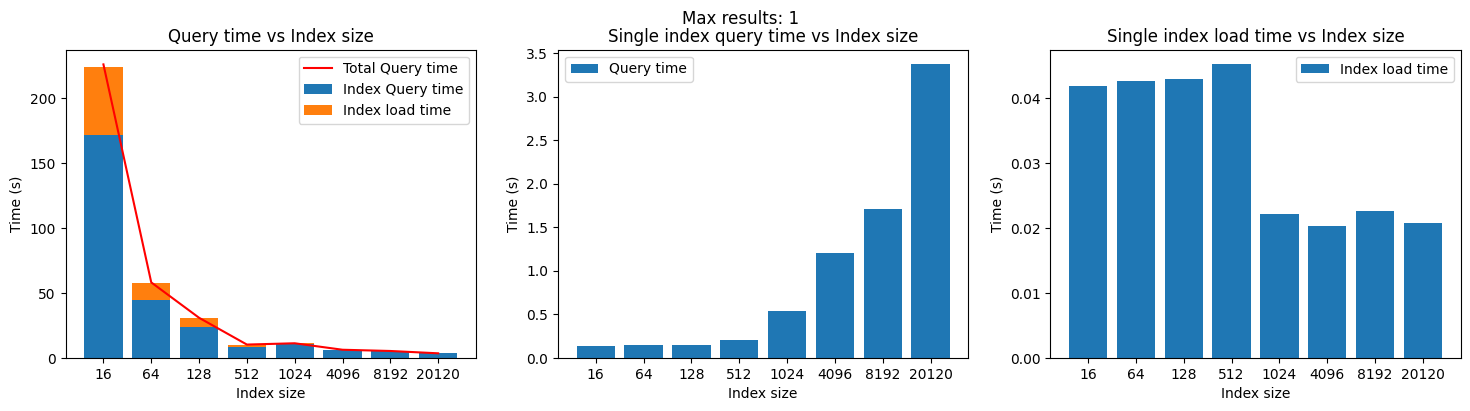

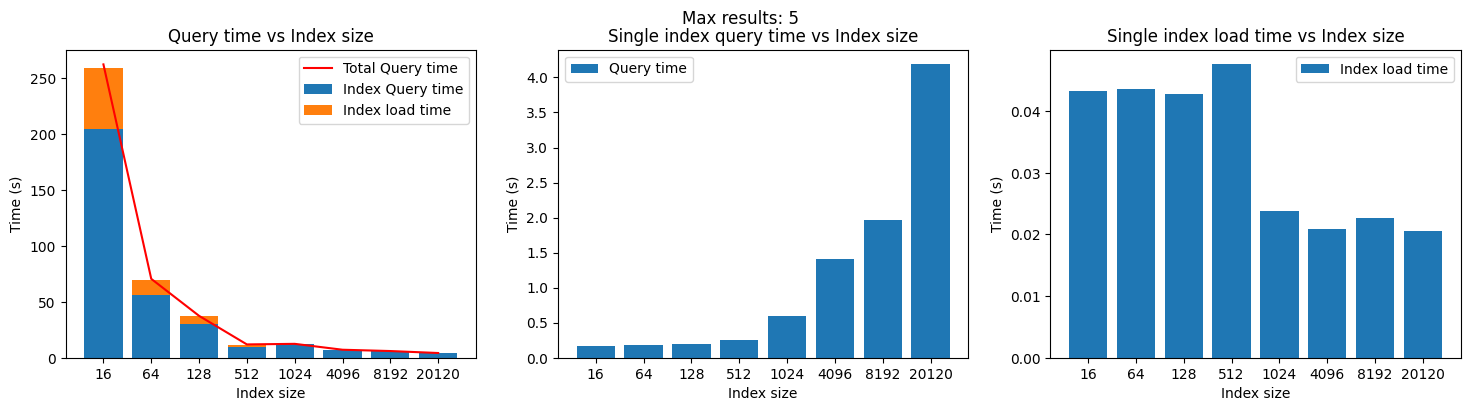

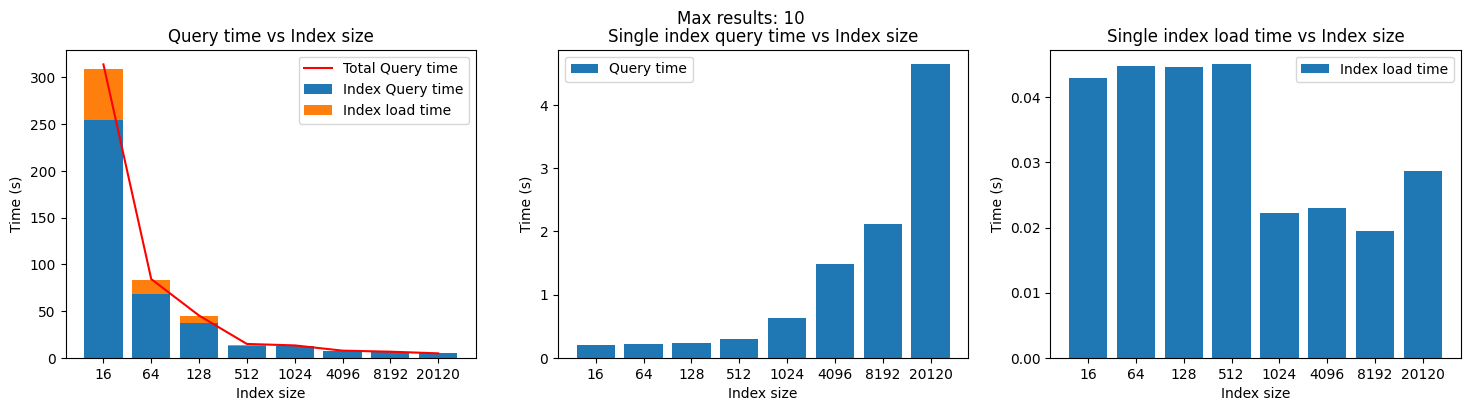

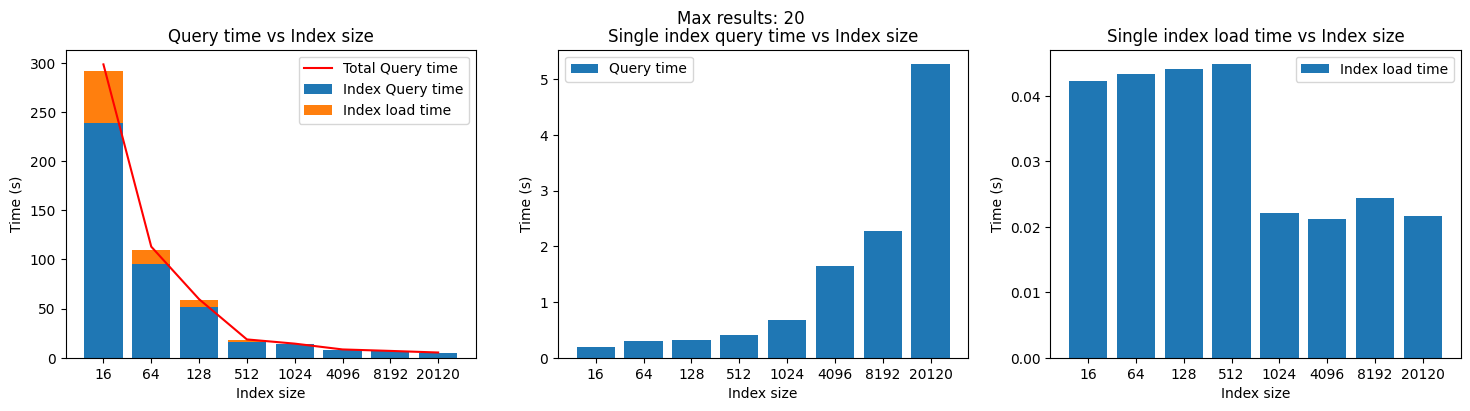

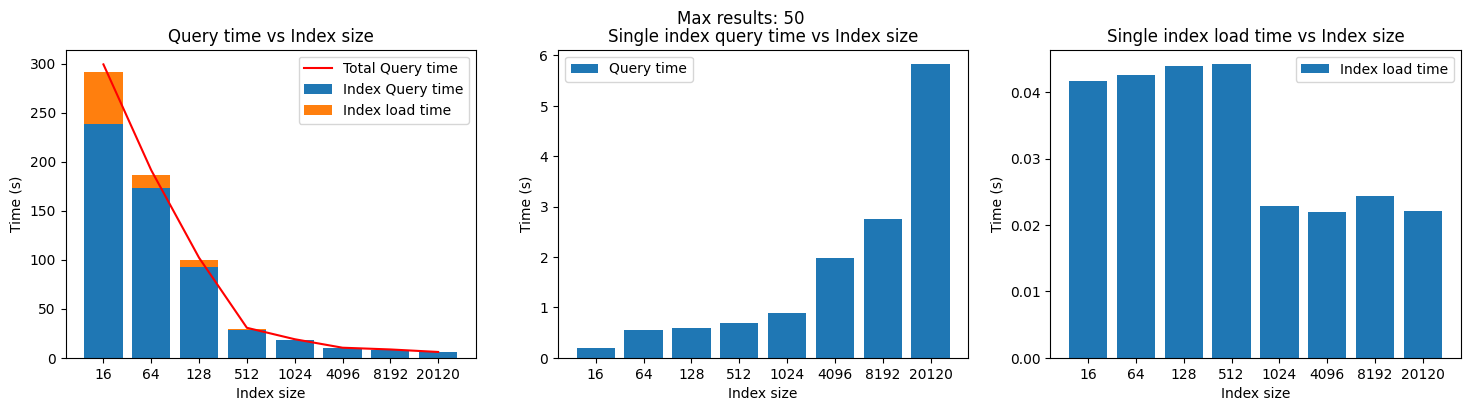

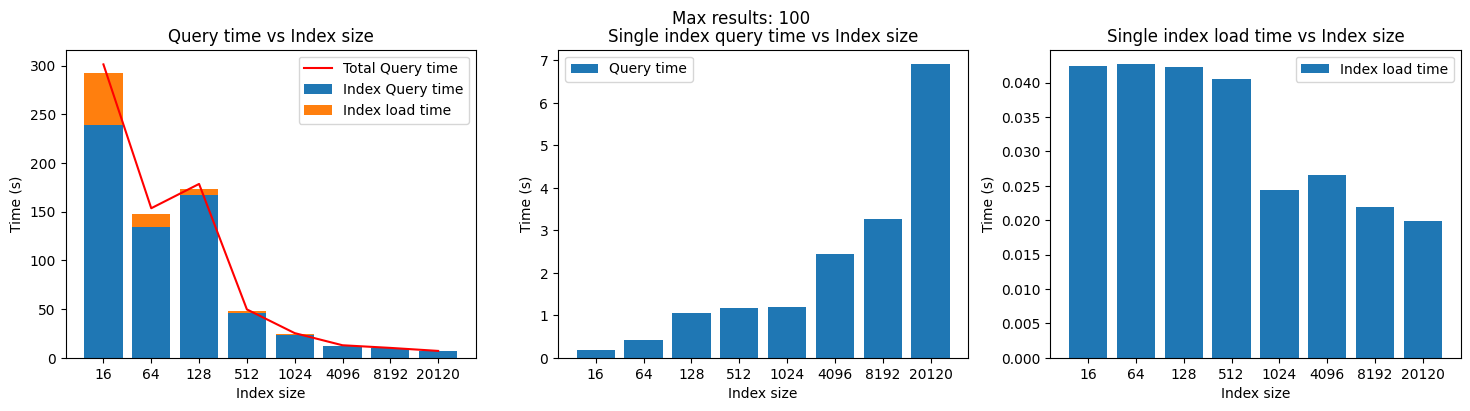

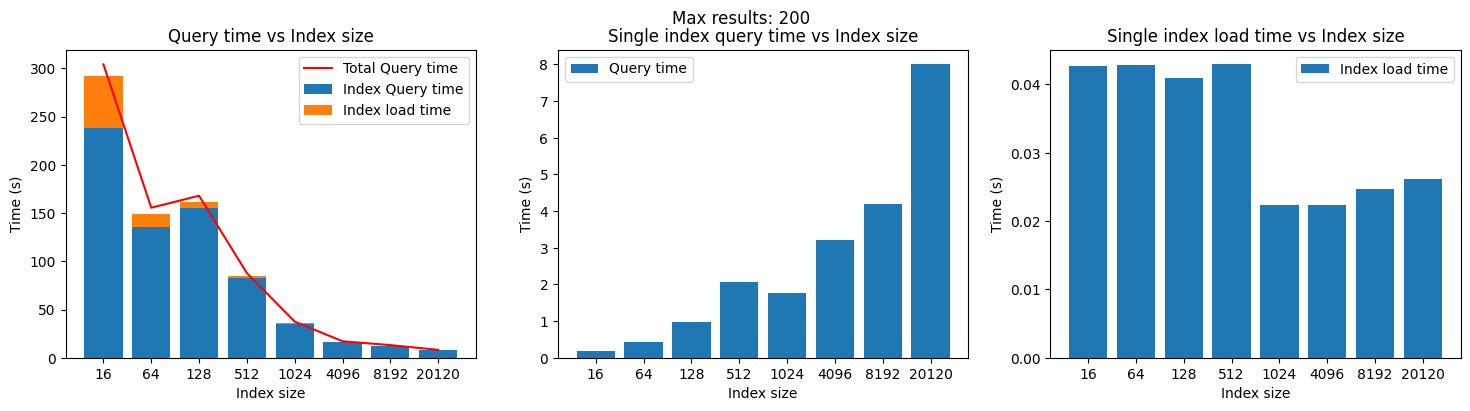

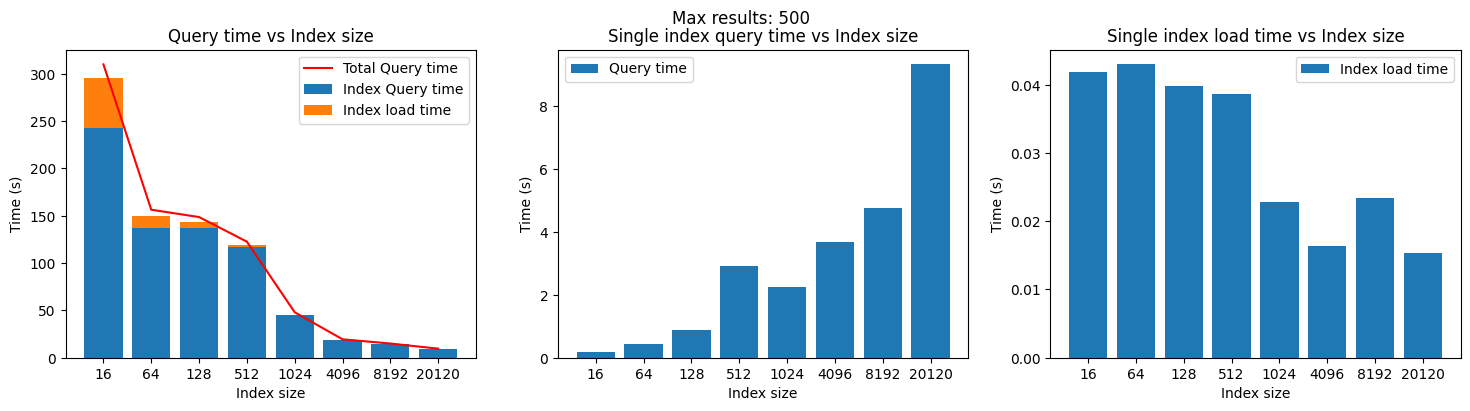

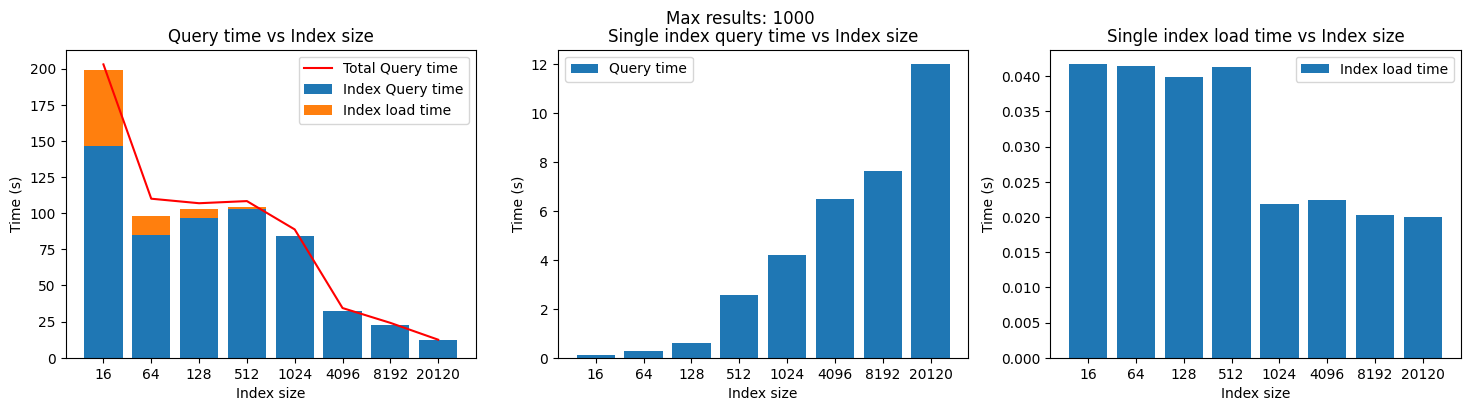

In [111]:
x = np.arange(len(index_sizes))
# max_results = [1000]

number_of_indexes = [math.ceil(20120/x) for x in index_sizes]

for i, maxr in enumerate(max_results):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

    res = stats_imagewise_results[maxr]
    stats = listify_stats(res)
    time_to_query_single_index = list(map(lambda x, y: x/y, stats["total_query_time"], number_of_indexes))

    ax1.plot(x, stats["total_time"], label="Total Query time", color='r')
    ax1.bar(x, stats["total_query_time"], label="Index Query time")
    ax1.bar(x, stats["total_load_time"], bottom=stats["total_query_time"], label="Index load time")

    ax2.bar(x, time_to_query_single_index, label="Query time")

    ax3.bar(x, stats["load_time_per_index"], label="Index load time")

    ax1.set_title("Query time vs Index size")
    ax1.set_xticks(x, index_sizes)
    ax1.set_xlabel("Index size")
    ax1.set_ylabel("Time (s)")
    ax1.legend()

    ax2.set_title("Single index query time vs Index size")
    ax2.set_xticks(x, index_sizes)
    ax2.set_xlabel("Index size")
    ax2.set_ylabel("Time (s)")
    ax2.legend()


    ax3.set_title("Single index load time vs Index size")
    ax3.set_xticks(x, index_sizes)
    ax3.set_xlabel("Index size")
    ax3.set_ylabel("Time (s)")
    ax3.legend()
    
    fig.suptitle(f"Max results: {maxr}")

# fig.savefig("../assets/images/query_time_vs_index_size.png")
plt.show()
# NOTE: Single index load time is not related to max_results

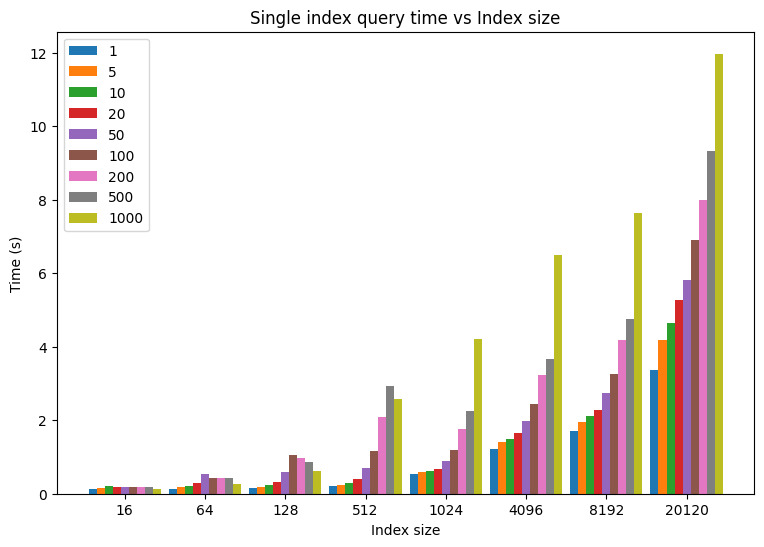

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
x = np.arange(len(index_sizes))
max_res_pos = np.linspace(-0.4, 0.4, len(max_results))

for i, maxr in enumerate(max_results):
    res = stats_imagewise_results[maxr]
    stats = listify_stats(res)
    time_to_query_single_index = list(map(lambda x, y: x/y, stats["total_query_time"], number_of_indexes))
    ax.bar(x + max_res_pos[i], time_to_query_single_index, width=0.1, label=maxr)

ax.set_title("Single index query time vs Index size")
ax.set_xticks(x, index_sizes)
ax.set_xlabel("Index size")
ax.set_ylabel("Time (s)")
ax.legend()

plt.show()
# What's interesting is that the max results that is ~= has the longest index time if it is slightly less than the index size.
# This could be because for the max res 500 and index size 512 it still has to do a search, but with max res 1000 and index size 512 it can just return all the results

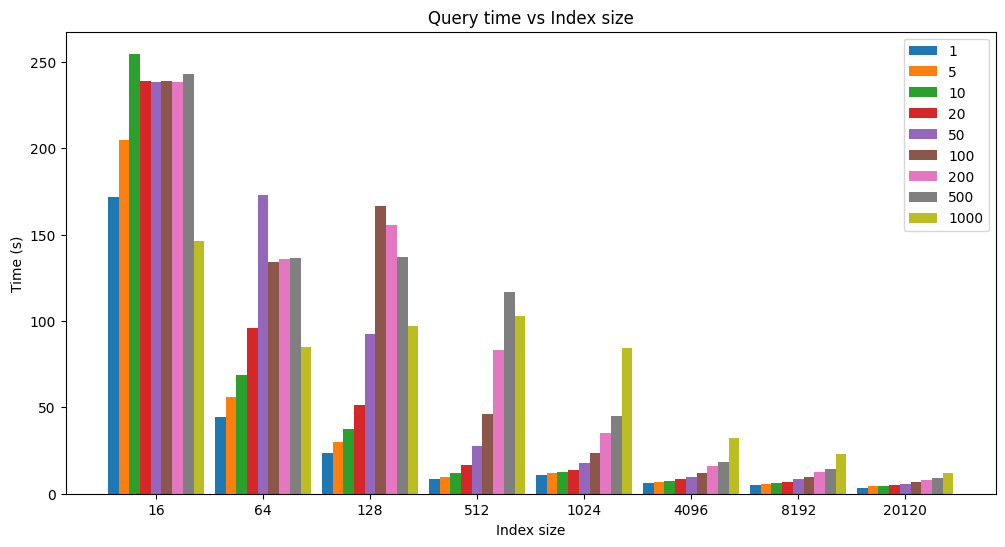

In [153]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
x = np.arange(len(index_sizes))
max_res_pos = np.linspace(-0.4, 0.4, len(max_results))

for i, maxr in enumerate(max_results):
    res = stats_imagewise_results[maxr]
    stats = listify_stats(res)
    # ax.plot(x, stats["total_time"], label="Total Query time")
    ax.bar(x + max_res_pos[i], stats["total_query_time"], width=0.1, label=maxr)


ax.set_title("Query time vs Index size")
ax.set_xticks(x, index_sizes)
ax.set_xlabel("Index size")
ax.set_ylabel("Time (s)")
ax.legend()

# What's interesting is that the max results that is ~= has the longest index time if it is slightly less than the index size.
# This could be because for the max res 500 and index size 512 it still has to do a search, but with max res 1000 and index size 512 it can just return all the results

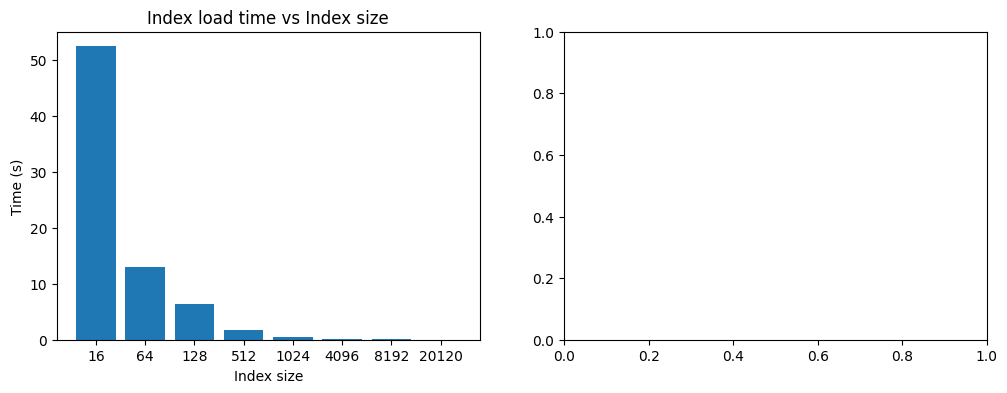

In [151]:
# TODO: Do against n_trees / search_k
# Sing index load time is constant -- more indexes => larger total index load time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# This is using the last index_load_time atm
ax1.bar(x, stats["total_load_time"])

ax1.set_title("Index load time vs Index size")
ax1.set_xticks(x, index_sizes)
ax1.set_xlabel("Index size")
ax1.set_ylabel("Time (s)")

plt.show()

I believe Annoy starts to lazy load the indexes past the index size of 512, which is why the <= 512 indexes are slower to load and faster to query than the > 512 indexes.

---

> The total query time does not *exactly* equal the sum of the query time and index load time. This is because it also includes extra python overhead.

> The maximum results allowed by annoy is 1000?

## Query Time vs Index Size

Here, we can see index load time *per index* is constant.
- However smaller indexes require more indexes to be loaded, leading to a larger total load time.
- The most significant factor is of course the query time, which decreases as the index size increases, as expected.
- This is because a larger index holds more images, so requires less indexes to be queried.


## Time to query single index vs Index size

- Obviously this one is unfair since smaller indexes will obviously take less time than larger indexes.
- However, it is interesting that the time to query a single index is fairly constant up until 512, and then it starts to increase.
- However, the amount the index time increases by is less than the amount the total query time decreases by.

## Conclusions

Finally, it is interesting that the 512 index slightly outperforms the 1024 index in query time. 

In [ ]:
"""
Max results per query: 1
	Index size 512 took 0.35632 seconds
	Total load time: 0.01508 seconds, 0.01508 per index
	Total query time: 0.33506, 0.00168 per query

Max results per query: 5
	Index size 512 took 0.29982 seconds
	Total load time: 0.00014 seconds, 0.00014 per index
	Total query time: 0.29665, 0.00148 per query

Max results per query: 10
	Index size 512 took 0.33133 seconds
	Total load time: 0.00012 seconds, 0.00012 per index
	Total query time: 0.32628, 0.00163 per query

Max results per query: 20
	Index size 512 took 0.36495 seconds
	Total load time: 0.00015 seconds, 0.00015 per index
	Total query time: 0.35696, 0.00178 per query

Max results per query: 50
	Index size 512 took 0.52374 seconds
	Total load time: 0.00141 seconds, 0.00141 per index
	Total query time: 0.50243, 0.00251 per query

Max results per query: 100
	Index size 512 took 0.68212 seconds
	Total load time: 0.00017 seconds, 0.00017 per index
	Total query time: 0.65211, 0.00326 per query

Max results per query: 200
	Index size 512 took 1.11366 seconds
	Total load time: 0.00014 seconds, 0.00014 per index
	Total query time: 1.05386, 0.00527 per query

Max results per query: 500
	Index size 512 took 2.34296 seconds
	Total load time: 0.00014 seconds, 0.00014 per index
	Total query time: 2.22419, 0.01112 per query

Max results per query: 1000
	Index size 512 took 4.47010 seconds
	Total load time: 0.00029 seconds, 0.00029 per index
	Total query time: 4.26663, 0.02133 per query
""";

In [ ]:
max_results_512 = [1, 5, 10, 20, 50, 100, 200, 500]
max_results_1024 = [1, 5, 10, 20, 50, 100, 200, 500, 1000]

time_per_query_1024 = [0.33506, 0.29665, 0.32628, 0.35696, 0.50243, 0.65211, 1.05386, 2.22419, 4.26663]
time_per_query_512 = [0.20996, 0.20204, 0.23592, 0.31013, 0.49875, 0.78132, 1.34248, 3.04603]

# Change these
max_results = max_results_512
time_per_query = time_per_query_512
nimgs = 512
max_results_res = pickle.load(open("../assets/max_results_res_512.pkl", "rb"))
plt_path = "../assets/images/max_results_512.png"

assert len(max_results) == len(time_per_query), f"{len(max_results)} != {len(time_per_query)}"

In [ ]:
(
    top_1_accuracies_max_results_all,
    top_5_accuracies_max_results_all,
) = get_top1_top5_accuracy(max_results_res, nimgs=nimgs)


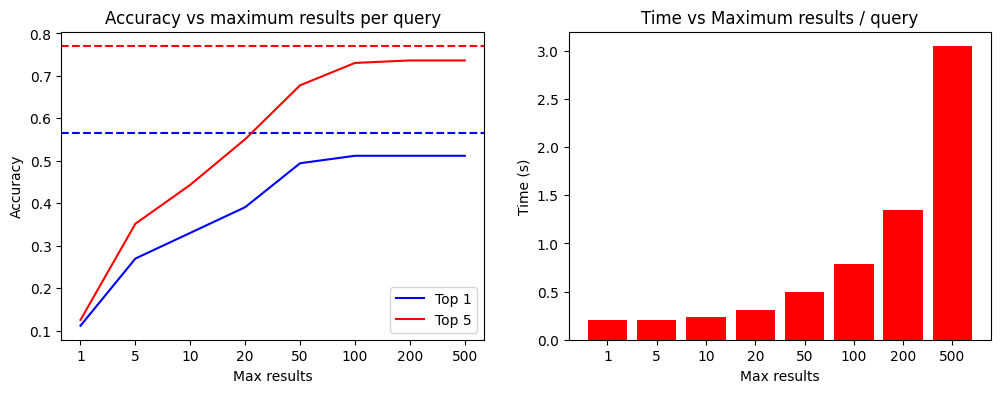

In [ ]:
x = np.arange(len(max_results))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(x, top_1_accuracies_max_results_all, label="Top 1", color='b')
ax1.axhline(y=top1_noindex_accuracy, linestyle='--', color='b')

ax1.plot(x, top_5_accuracies_max_results_all, label="Top 5", color='r')
ax1.axhline(y=top5_noindex_accuracy, linestyle='--', color='r')

ax1.set_xticks(x, max_results)
ax1.legend()
ax1.set_xlabel("Max results")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy vs maximum results per query")

ax2.bar(x, time_per_query, color='r')
ax2.set_title("Time vs Maximum results / query")
ax2.set_xticks(x, max_results)
ax2.set_xlabel("Max results")
ax2.set_ylabel("Time (s)")

fig.savefig(plt_path)
plt.show()

In [92]:
total_each_class = dataset.total_each_class("val")
total_dataset = dataset.get_num_images("val")

querywise_queries = pickle.load(open("../assets/imagenet_data_querywise_512.pkl", "rb"))


In [110]:
max_max = 0
ann_queries = querywise_queries[512]

for q in ann_queries.keys():
    max_max = max(max_max, max(map(lambda x: x.dist, ann_queries[q])))
max_max

1.2666112184524536

In [ ]:
flattened_images = [i for j in ann_queries.values() for i in j]

In [ ]:
from clip_index.stats import annoy_query_stats, QueryStats

import torch
thresholds = torch.arange(0.95, 1.25, 0.01)

# thres_stats = torch.empty(len(querywise_queries), len(thresholds))
stats: list[list[QueryStats]] = []


for j, thres in enumerate(thresholds):
    qstats = []
    for q, imgs in ann_queries.items():
        thres_imgs = filter(lambda x: x.dist < thres, imgs)
        qstat = annoy_query_stats(q, thres_imgs, total_each_class[q], total_dataset)
        qstats.append(qstat)
    stats.append(qstats)

a = lambda x: [np.mean([x(qstat) for qstat in qstats]) for qstats in stats]

In [ ]:
recalls = a(lambda x: x.recall())
precisions = a(lambda x: x.precision())
f1s = a(lambda x: x.f1())
accuracies = a(lambda x: x.accuracy())

false_pos_rate = list(map(lambda x: 1 - x, recalls))

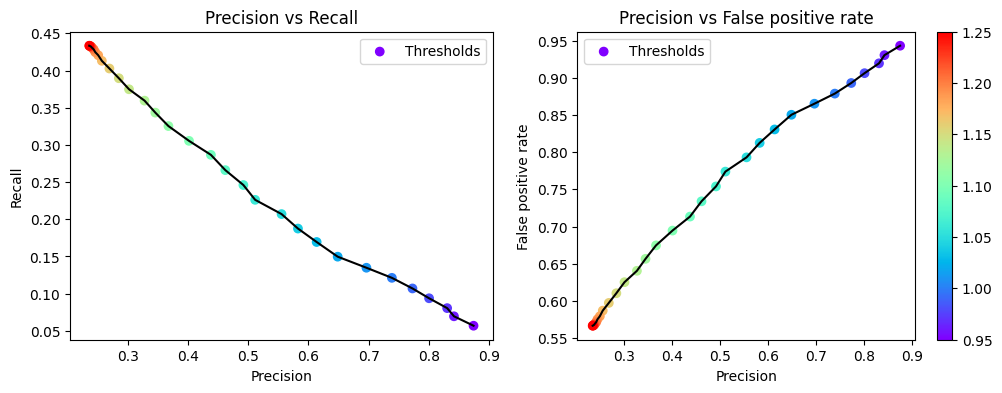

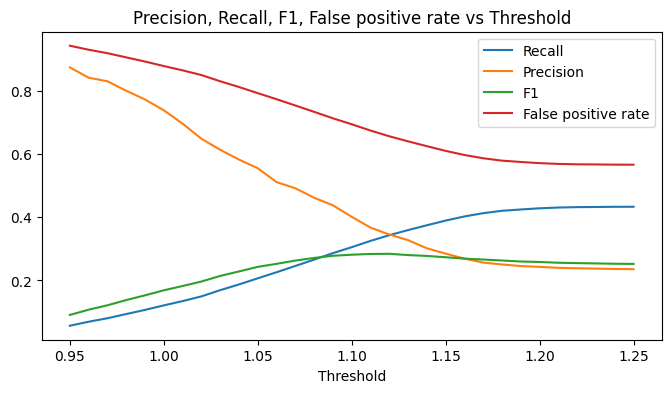

In [ ]:
import matplotlib
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
colors = np.linspace(0, 1, len(thresholds))

ax1.plot(precisions, recalls, c='k')
ax1.scatter(precisions, recalls, c=colors, cmap='rainbow', label=f"Thresholds")

ax1.set_xlabel("Precision")
ax1.set_ylabel("Recall")
ax1.set_title("Precision vs Recall")
ax1.legend()

ax2.plot(precisions, false_pos_rate, c='k')
ax2.scatter(precisions, false_pos_rate, c=colors, cmap='rainbow', label="Thresholds")
ax2.set_xlabel("Precision")
ax2.set_ylabel("False positive rate")
ax2.set_title("Precision vs False positive rate")
ax2.legend()

fig.colorbar(cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=thresholds[0], vmax=thresholds[-1]), cmap='rainbow'), ax=ax2)
fig.savefig("../assets/images/roc.png")

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(thresholds, recalls, label="Recall")
ax.plot(thresholds, precisions, label="Precision")
ax.plot(thresholds, f1s, label="F1")
ax.plot(thresholds, false_pos_rate, label="False positive rate")
ax.set_xlabel("Threshold")
ax.set_title("Precision, Recall, F1, False positive rate vs Threshold")
ax.legend()

fig.savefig("../assets/images/stats_comparison.png")

plt.show()
# This is built on the 512 index, with a max results of 500
# TODO: Recall and false positive rate are the same thing!!